## Using Deep Neural Networks for Prediction

We will start by selecting a reasonable number of features using a sklearn pipeline, then we will try to train simple bechmark neural networks. 

### Feature selection pipeline

Let's select best features after collecting up to 2-grams.


In [1]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import MaxAbsScaler,FunctionTransformer, Imputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_extraction.text import HashingVectorizer

# First we build two utility functions to parse numeric and text data, 
# and wrap them using FunctionTransformer, so that they can be integrated into a sklearn pipeline:
def text_columns(X_train):
    return X_train.TEXT_FEATURES

def numeric_columns(X_train):
    numeric = ['APPLICANT_PRIOR_CLEARANCE_TO_DATE','DEVICENAME_PRIOR_CLEARANCE_TO_DATE']
    temp = X_train[numeric]
    return temp

get_numeric_data = FunctionTransformer(func = numeric_columns, validate=False) 
get_text_data = FunctionTransformer(func = text_columns,validate=False) 
# Note how we avoid putting any arguments into text_columns and numeric_columns

# We also need to create our regex token pattern to use in HashingVectorizer. 
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'   
#Note this regex will match either a whitespace or a punctuation to tokenize the string vector on these preferences  

# We also need to redefine the default feature selection function for regression to properly place into our pipeline:
def f_regression(X,Y):
    import sklearn
    return sklearn.feature_selection.f_regression(X,Y,center = False) # default is center = True


pipeline510k_NNet1 = Pipeline([
    
    ("union",FeatureUnion( # Note that FeatureUnion() accepts list of tuples, the first half of each tuple is the name of the transformer
        
        transformer_list = [
            
            ("numeric_subpipeline", Pipeline([ # Note we have subpipeline branches inside the main pipeline
                
                ("parser",get_numeric_data), # Step1: parse the numeric data (note how we avoid () when using FunctionTransformer objects)
                ("imputer",Imputer()), # Step2: impute missing values (we don't expect any)
            
            ])), # Branching point of the FeatureUnion
            
            ("text_subpipeline",Pipeline([
            
                ("parser",get_text_data), # Step1: parse the text data 
                ("tokenizer",HashingVectorizer(token_pattern= TOKENS_ALPHANUMERIC,n_features= 2*(2 ** 18),decode_error='ignore',
                                             stop_words = "english",# We will remove English stop words before tokenization
                                             ngram_range = (1,2), # We will tokenize to single words only
                                             non_negative=True, norm=None, binary=True  
                                            )) # Step2: use HashingVectorizer for automated tokenization and feature extraction
                                           
                
            ]))
        ]
    
    )),# Branching point to the main pipeline: at this point all features are numeric
    
    ("scaler",MaxAbsScaler()) # Scale the features
    
])


In [2]:
import pickle
# Load Training and Validation sets
disk = "D:\Data_science\GitHub\Predictive-Modeling-510k-decision-time"
# Validation set 
with open(disk+"\X_val.pkl","rb") as f:
    X_val=pickle.load(f)

with open(disk+"\y_val.pkl","rb") as f:
    y_val=pickle.load(f)
    
# Training set (Locked down)
with open(disk+"\X_train.pkl","rb") as f:
    X_train=pickle.load(f)

with open(disk+"\y_train.pkl","rb") as f:
    y_train=pickle.load(f) 

In [3]:
import datetime
from warnings import filterwarnings
import numpy as np

filterwarnings("ignore")

start = datetime.datetime.now()

X_train_trans_NNet = pipeline510k_NNet1.fit(X_train, y_train).transform(X_train)

end = datetime.datetime.now()
print("Completed processing X_train in: " + str((end-start).seconds/60) + " minutes.")

start = datetime.datetime.now()

X_val_trans_NNet = pipeline510k_NNet1.transform(X_val)

end = datetime.datetime.now()
print("Completed processing X_val in: " + str((end-start).seconds/60) + " minutes.")

Completed processing X_train in: 1.3333333333333333 minutes.
Completed processing X_val in: 0.31666666666666665 minutes.


In [4]:
print(X_train_trans_NNet.shape)
print(X_val_trans_NNet.shape)
print(type(X_train_trans_NNet))
print(type(X_val_trans_NNet))

(32275, 524290)
(15899, 524290)
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>


In [12]:
from sklearn.metrics import median_absolute_error
filterwarnings("ignore")

n_features_list = [300,5000,10000,20000,50000,100000,200000,400000,500000]
mae_list = []
time_list = []

for n_features in n_features_list:
    print("Training model using "+ str(n_features)+ " features.")
    
    # Testing feature selection based on training set
    Xt = SelectKBest(f_regression,n_features).fit(X_train_trans_NNet,y_train).transform(X_train_trans_NNet)
    Xv = SelectKBest(f_regression,n_features).fit(X_train_trans_NNet,y_train).transform(X_val_trans_NNet)

    start = datetime.datetime.now()
    
    # Fixed model structure 
    from keras import models, metrics, layers
  
    network1 = models.Sequential()
    network1.add(layers.Dense(8,activation="relu", input_shape = (Xt.shape[1],)))
    network1.add(layers.Dense(16,activation="relu"))
    network1.add(layers.Dense(8,activation="relu"))
    network1.add(layers.Dense(1))
    network1.compile(optimizer= "adam", loss= "mean_absolute_error", metrics= [metrics.mean_absolute_error])
    history_net1 = network1.fit(Xt,np.log(y_train),  
                                 epochs=10,batch_size=200,validation_split= 0.3)
    preds = network1.predict(Xv)

    # Out-of-box performance using validation set
    mae = median_absolute_error(y_val,np.exp(preds))

    end = datetime.datetime.now()
    
    mae_list.append(mae)
    time_list.append((end-start).seconds/60)

    print("Completed model fit and predictions using "+ str(n_features) + " in: " + str((end-start).seconds/60) + " minutes.")
    print("Median Absolute Error: "+ str(mae) + " features.")
    print("*" * 100)


Training model using 300 features.
Train on 22592 samples, validate on 9683 samples
Epoch 1/10
22592/22592 [==============================] - 0s 19us/step - loss: 1.0961 - mean_absolute_error: 1.0961 - val_loss: 0.7426 - val_mean_absolute_error: 0.7426
Epoch 2/10
22592/22592 [==============================] - 0s 10us/step - loss: 0.7111 - mean_absolute_error: 0.7111 - val_loss: 0.7013 - val_mean_absolute_error: 0.7013
Epoch 3/10
22592/22592 [==============================] - 0s 9us/step - loss: 0.6825 - mean_absolute_error: 0.6825 - val_loss: 0.6892 - val_mean_absolute_error: 0.6892
Epoch 4/10
22592/22592 [==============================] - 0s 10us/step - loss: 0.6634 - mean_absolute_error: 0.6634 - val_loss: 0.6627 - val_mean_absolute_error: 0.6627
Epoch 5/10
22592/22592 [==============================] - 0s 9us/step - loss: 0.6471 - mean_absolute_error: 0.6471 - val_loss: 0.6492 - val_mean_absolute_error: 0.6492
Epoch 6/10
22592/22592 [==============================] - 0s 10us/step - 

22592/22592 [==============================] - 11s 469us/step - loss: 0.9720 - mean_absolute_error: 0.9720 - val_loss: 0.6274 - val_mean_absolute_error: 0.6274
Epoch 2/10
22592/22592 [==============================] - 11s 471us/step - loss: 0.5549 - mean_absolute_error: 0.5549 - val_loss: 0.5788 - val_mean_absolute_error: 0.5788
Epoch 3/10
22592/22592 [==============================] - 10s 450us/step - loss: 0.4602 - mean_absolute_error: 0.4602 - val_loss: 0.5534 - val_mean_absolute_error: 0.5534
Epoch 4/10
22592/22592 [==============================] - 10s 455us/step - loss: 0.3989 - mean_absolute_error: 0.3989 - val_loss: 0.5513 - val_mean_absolute_error: 0.5513
Epoch 5/10
22592/22592 [==============================] - 10s 437us/step - loss: 0.3531 - mean_absolute_error: 0.3531 - val_loss: 0.5498 - val_mean_absolute_error: 0.5498
Epoch 6/10
22592/22592 [==============================] - 10s 441us/step - loss: 0.3212 - mean_absolute_error: 0.3212 - val_loss: 0.5514 - val_mean_absolute

Epoch 2/10
22592/22592 [==============================] - 89s 4ms/step - loss: 3.8173 - mean_absolute_error: 3.8173 - val_loss: 3.3884 - val_mean_absolute_error: 3.3884
Epoch 3/10
22592/22592 [==============================] - 89s 4ms/step - loss: 0.9152 - mean_absolute_error: 0.9152 - val_loss: 0.6038 - val_mean_absolute_error: 0.6038
Epoch 4/10
22592/22592 [==============================] - 89s 4ms/step - loss: 0.5171 - mean_absolute_error: 0.5171 - val_loss: 0.5854 - val_mean_absolute_error: 0.5854
Epoch 5/10
22592/22592 [==============================] - 89s 4ms/step - loss: 0.3687 - mean_absolute_error: 0.3687 - val_loss: 0.5729 - val_mean_absolute_error: 0.5729
Epoch 6/10
22592/22592 [==============================] - 89s 4ms/step - loss: 0.2909 - mean_absolute_error: 0.2909 - val_loss: 0.5677 - val_mean_absolute_error: 0.5677
Epoch 7/10
22592/22592 [==============================] - 89s 4ms/step - loss: 0.2393 - mean_absolute_error: 0.2393 - val_loss: 0.5702 - val_mean_absolute_

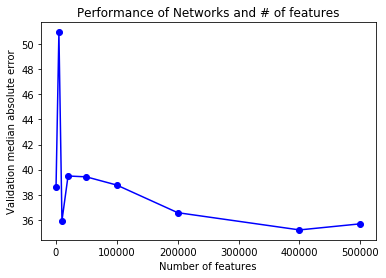

In [22]:
import matplotlib.pyplot as plt
plt.plot(n_features_list, mae_list, marker = "o", c = "b")
plt.title("Performance of Networks and # of features")
plt.xlabel("Number of features")
plt.ylabel("Validation median absolute error")
plt.show()

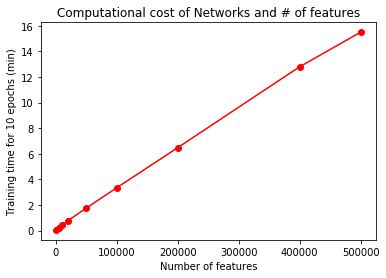

In [24]:
plt.plot(n_features_list, time_list, marker = "o", c = "r")
plt.title("Computational cost of Networks and # of features")
plt.xlabel("Number of features")
plt.ylabel("Training time for 10 epochs (min)")
plt.show()

We will use 10000 features since this provides the best performance in a reasonable computational cost.

### Bechmark Neural Networks


In [25]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import MaxAbsScaler,FunctionTransformer, Imputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_extraction.text import HashingVectorizer

# First we build two utility functions to parse numeric and text data, 
# and wrap them using FunctionTransformer, so that they can be integrated into a sklearn pipeline:
def text_columns(X_train):
    return X_train.TEXT_FEATURES

def numeric_columns(X_train):
    numeric = ['APPLICANT_PRIOR_CLEARANCE_TO_DATE','DEVICENAME_PRIOR_CLEARANCE_TO_DATE']
    temp = X_train[numeric]
    return temp

get_numeric_data = FunctionTransformer(func = numeric_columns, validate=False) 
get_text_data = FunctionTransformer(func = text_columns,validate=False) 
# Note how we avoid putting any arguments into text_columns and numeric_columns

# We also need to create our regex token pattern to use in HashingVectorizer. 
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'   
#Note this regex will match either a whitespace or a punctuation to tokenize the string vector on these preferences  

# We also need to redefine the default feature selection function for regression to properly place into our pipeline:
def f_regression(X,Y):
    import sklearn
    return sklearn.feature_selection.f_regression(X,Y,center = False) # default is center = True


pipeline510k_NNet1 = Pipeline([
    
    ("union",FeatureUnion( # Note that FeatureUnion() accepts list of tuples, the first half of each tuple is the name of the transformer
        
        transformer_list = [
            
            ("numeric_subpipeline", Pipeline([ # Note we have subpipeline branches inside the main pipeline
                
                ("parser",get_numeric_data), # Step1: parse the numeric data (note how we avoid () when using FunctionTransformer objects)
                ("imputer",Imputer()), # Step2: impute missing values (we don't expect any)
            
            ])), # Branching point of the FeatureUnion
            
            ("text_subpipeline",Pipeline([
            
                ("parser",get_text_data), # Step1: parse the text data 
                ("tokenizer",HashingVectorizer(token_pattern= TOKENS_ALPHANUMERIC,n_features= 2*(2 ** 18),decode_error='ignore',
                                             stop_words = "english",# We will remove English stop words before tokenization
                                             ngram_range = (1,2), # We will tokenize to single words only
                                             non_negative=True, norm=None, binary=True  
                                            )) # Step2: use HashingVectorizer for automated tokenization and feature extraction
                                           
                
            ]))
        ]
    
    )),# Branching point to the main pipeline: at this point all features are numeric
    
    ("scaler",MaxAbsScaler()), # Scale the features
    ("dim_red", SelectKBest(f_regression,10000))
])


In [26]:
import datetime
from warnings import filterwarnings
import numpy as np

filterwarnings("ignore")

start = datetime.datetime.now()

X_train_trans_NNet = pipeline510k_NNet1.fit(X_train, y_train).transform(X_train)

end = datetime.datetime.now()
print("Completed processing X_train in: " + str((end-start).seconds/60) + " minutes.")

start = datetime.datetime.now()

X_val_trans_NNet = pipeline510k_NNet1.transform(X_val)

end = datetime.datetime.now()
print("Completed processing X_val in: " + str((end-start).seconds/60) + " minutes.")

Completed processing X_train in: 1.45 minutes.
Completed processing X_val in: 0.3333333333333333 minutes.


In [27]:
print(X_train_trans_NNet.shape)
print(X_val_trans_NNet.shape)
print(type(X_train_trans_NNet))
print(type(X_val_trans_NNet))

(32275, 10000)
(15899, 10000)
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>


In [40]:
from keras import models, metrics, layers
# Note that csr type of sparse matrix runs significantly faster in keras neural network implementation
np.random.seed(123)

network1 = models.Sequential()
network1.add(layers.Dense(32,activation="relu", input_shape = (X_train_trans_NNet.shape[1],)))
network1.add(layers.Dense(32,activation="relu"))
network1.add(layers.Dense(32,activation="relu"))
network1.add(layers.Dense(32,activation="relu"))
network1.add(layers.Dense(1))
network1.compile(optimizer= "adam", loss= "mean_absolute_error", metrics= [metrics.mean_absolute_error])
history_net1 = network1.fit(X_train_trans_NNet,np.log(y_train),  
                             epochs=7,batch_size=200,validation_split= 0.3)

Train on 22592 samples, validate on 9683 samples
Epoch 1/7
22592/22592 [==============================] - 3s 144us/step - loss: 0.8268 - mean_absolute_error: 0.8268 - val_loss: 0.5981 - val_mean_absolute_error: 0.5981
Epoch 2/7
22592/22592 [==============================] - 3s 121us/step - loss: 0.5524 - mean_absolute_error: 0.5524 - val_loss: 0.5579 - val_mean_absolute_error: 0.5579
Epoch 3/7
22592/22592 [==============================] - 3s 119us/step - loss: 0.5046 - mean_absolute_error: 0.5046 - val_loss: 0.5605 - val_mean_absolute_error: 0.5605
Epoch 4/7
22592/22592 [==============================] - 3s 119us/step - loss: 0.4750 - mean_absolute_error: 0.4750 - val_loss: 0.5566 - val_mean_absolute_error: 0.5566
Epoch 5/7
22592/22592 [==============================] - 3s 119us/step - loss: 0.4621 - mean_absolute_error: 0.4621 - val_loss: 0.5529 - val_mean_absolute_error: 0.5529
Epoch 6/7
22592/22592 [==============================] - 3s 120us/step - loss: 0.4461 - mean_absolute_erro

In [41]:
from sklearn.metrics import median_absolute_error
preds = network1.predict(X_val_trans_NNet)

# Out-of-box performance using validation set
mae = median_absolute_error(y_val,np.exp(preds))

print("Median Absolute Error: ", str(mae))

Median Absolute Error:  39.32270812988281


In [42]:
# Bechmark model performance on validation set plotted
def plot_performance(true, preds, model_name):
    import matplotlib.pyplot as plt
    import numpy as np
    from sklearn.metrics import median_absolute_error 
    mae = median_absolute_error(true,np.exp(preds))
    plt.scatter(x = np.exp(preds), y = true, c = 'blue', s = 3, alpha = 0.2)
    plt.plot([0,1200],[0,1200], "--k")
    plt.xlabel("Predictions")
    plt.ylabel("True targets")
    plt.text(0,1100, r"MAE = %.2f"%(mae))
    plt.title("Predictive performance of "+ model_name + " model" )

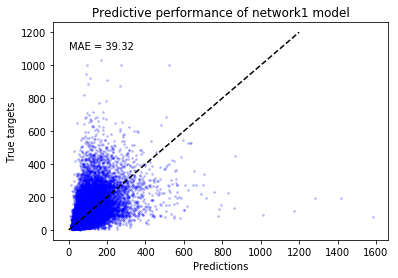

In [43]:
plot_performance(true= y_val, preds= preds, model_name= "network1")

#### Experiment to monitor network structure and validation performance

In [45]:
from sklearn.metrics import median_absolute_error
filterwarnings("ignore")

neurons_list = [6,16,32,64,72,96,108,240]
mae_list = []
time_list = []

for neurons in neurons_list:
    print("Training model using "+ str(neurons)+ " neurons.")
    start = datetime.datetime.now()
    
    # Fixed model structure 
    from keras import models, metrics, layers, callbacks
  
    np.random.seed(123)
    Earlystopping_monitor = callbacks.EarlyStopping(patience=2)
    
    network1 = models.Sequential()
    network1.add(layers.Dense(neurons,activation="relu", input_shape = (X_train_trans_NNet.shape[1],)))
    network1.add(layers.Dense(neurons,activation="relu"))
    network1.add(layers.Dense(neurons,activation="relu"))
    network1.add(layers.Dense(neurons,activation="relu"))
    network1.add(layers.Dense(1))
    network1.compile(optimizer= "adam", loss= "mean_absolute_error", metrics= [metrics.mean_absolute_error])
    history_net1 = network1.fit(X_train_trans_NNet,np.log(y_train),  callbacks=[Earlystopping_monitor],
                                 epochs=100,batch_size=200,validation_split= 0.3)
    
    preds = network1.predict(X_val_trans_NNet)

    # Out-of-box performance using validation set
    mae = median_absolute_error(y_val,np.exp(preds))

    end = datetime.datetime.now()
    
    mae_list.append(mae)
    time_list.append((end-start).seconds/60)

    print("Completed model fit and predictions using "+ str(neurons) + " in: " + str((end-start).seconds/60) + " minutes.")
    print("Median Absolute Error: "+ str(mae) )
    print("*" * 100)


Training model using 6 neurons.
Train on 22592 samples, validate on 9683 samples
Epoch 1/100
22592/22592 [==============================] - 3s 133us/step - loss: 4.3138 - mean_absolute_error: 4.3138 - val_loss: 4.1152 - val_mean_absolute_error: 4.1152
Epoch 2/100
22592/22592 [==============================] - 2s 104us/step - loss: 3.7866 - mean_absolute_error: 3.7866 - val_loss: 3.3851 - val_mean_absolute_error: 3.3851
Epoch 3/100
22592/22592 [==============================] - 2s 107us/step - loss: 2.7939 - mean_absolute_error: 2.7939 - val_loss: 2.1023 - val_mean_absolute_error: 2.1023
Epoch 4/100
22592/22592 [==============================] - 2s 107us/step - loss: 1.3729 - mean_absolute_error: 1.3729 - val_loss: 0.8326 - val_mean_absolute_error: 0.8326
Epoch 5/100
22592/22592 [==============================] - 2s 107us/step - loss: 0.7221 - mean_absolute_error: 0.7221 - val_loss: 0.7024 - val_mean_absolute_error: 0.7024
Epoch 6/100
22592/22592 [==============================] - 2s 10

Completed model fit and predictions using 96 in: 0.36666666666666664 minutes.
Median Absolute Error: 36.579071044921875
****************************************************************************************************
Training model using 108 neurons.
Train on 22592 samples, validate on 9683 samples
Epoch 1/100
22592/22592 [==============================] - 5s 217us/step - loss: 0.7428 - mean_absolute_error: 0.7428 - val_loss: 0.5776 - val_mean_absolute_error: 0.5776
Epoch 2/100
22592/22592 [==============================] - 4s 180us/step - loss: 0.5322 - mean_absolute_error: 0.5322 - val_loss: 0.5596 - val_mean_absolute_error: 0.5596
Epoch 3/100
22592/22592 [==============================] - 4s 179us/step - loss: 0.4946 - mean_absolute_error: 0.4946 - val_loss: 0.5519 - val_mean_absolute_error: 0.5519
Epoch 4/100
22592/22592 [==============================] - 4s 183us/step - loss: 0.4510 - mean_absolute_error: 0.4510 - val_loss: 0.5530 - val_mean_absolute_error: 0.5530
Epoch 5/100


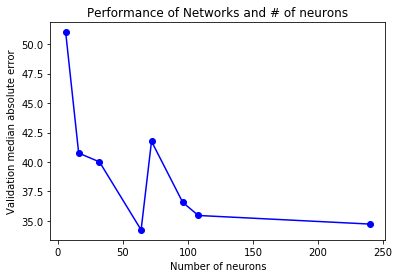

In [46]:
import matplotlib.pyplot as plt
plt.plot(neurons_list, mae_list, marker = "o", c = "b")
plt.title("Performance of Networks and # of neurons")
plt.xlabel("Number of neurons")
plt.ylabel("Validation median absolute error")
plt.show()

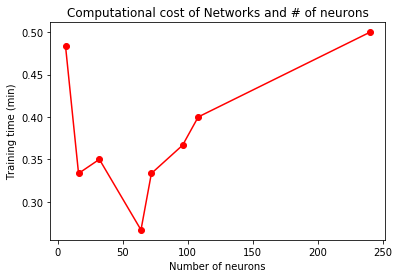

In [48]:
plt.plot(neurons_list, time_list, marker = "o", c = "r")
plt.title("Computational cost of Networks and # of neurons")
plt.xlabel("Number of neurons")
plt.ylabel("Training time (min)")
plt.show()

It looks like having 64 neurons give the best performance in this setting. How about if we increase the number of layers? 

Train on 22592 samples, validate on 9683 samples
Epoch 1/100
22592/22592 [==============================] - 4s 184us/step - loss: 0.8306 - mean_absolute_error: 0.8306 - val_loss: 0.6068 - val_mean_absolute_error: 0.6068
Epoch 2/100
22592/22592 [==============================] - 3s 151us/step - loss: 0.5535 - mean_absolute_error: 0.5535 - val_loss: 0.5545 - val_mean_absolute_error: 0.5545
Epoch 3/100
22592/22592 [==============================] - 3s 148us/step - loss: 0.5006 - mean_absolute_error: 0.5006 - val_loss: 0.5493 - val_mean_absolute_error: 0.5493
Epoch 4/100
22592/22592 [==============================] - 3s 148us/step - loss: 0.4655 - mean_absolute_error: 0.4655 - val_loss: 0.5510 - val_mean_absolute_error: 0.5510
Epoch 5/100
22592/22592 [==============================] - 3s 150us/step - loss: 0.4429 - mean_absolute_error: 0.4429 - val_loss: 0.5610 - val_mean_absolute_error: 0.5610


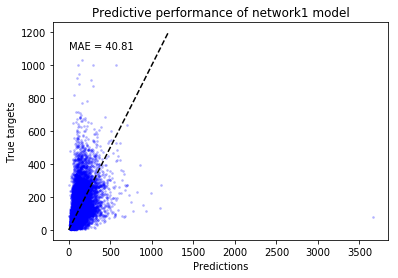

In [50]:
neurons = 64
np.random.seed(123)
Earlystopping_monitor = callbacks.EarlyStopping(patience=2)
    
network1 = models.Sequential()
network1.add(layers.Dense(neurons,activation="relu", input_shape = (X_train_trans_NNet.shape[1],)))
network1.add(layers.Dense(neurons,activation="relu"))
network1.add(layers.Dense(neurons,activation="relu"))
network1.add(layers.Dense(neurons,activation="relu"))
network1.add(layers.Dense(neurons,activation="relu"))
network1.add(layers.Dense(1))
network1.compile(optimizer= "adam", loss= "mean_absolute_error", metrics= [metrics.mean_absolute_error])
history_net1 = network1.fit(X_train_trans_NNet,np.log(y_train),  callbacks=[Earlystopping_monitor],
                                 epochs=100,batch_size=200,validation_split= 0.3)
    
preds = network1.predict(X_val_trans_NNet)

# Out-of-box performance using validation set
mae = median_absolute_error(y_val,np.exp(preds)) 

plot_performance(true= y_val, preds= preds, model_name= "network1")

#### Adding dropout regularization

Train on 32275 samples, validate on 15899 samples
Epoch 1/100
32275/32275 [==============================] - 7s 215us/step - loss: 1.7989 - mean_absolute_error: 1.4611 - val_loss: 0.6135 - val_mean_absolute_error: 0.5778
Epoch 2/100
32275/32275 [==============================] - 5s 157us/step - loss: 0.6036 - mean_absolute_error: 0.5720 - val_loss: 0.5819 - val_mean_absolute_error: 0.5513
Epoch 3/100
32275/32275 [==============================] - 5s 156us/step - loss: 0.5720 - mean_absolute_error: 0.5395 - val_loss: 0.5706 - val_mean_absolute_error: 0.5384
Epoch 4/100
32275/32275 [==============================] - 5s 157us/step - loss: 0.5445 - mean_absolute_error: 0.5132 - val_loss: 0.5600 - val_mean_absolute_error: 0.5332
Epoch 5/100
32275/32275 [==============================] - 5s 158us/step - loss: 0.5294 - mean_absolute_error: 0.5014 - val_loss: 0.5610 - val_mean_absolute_error: 0.5346
Epoch 6/100
32275/32275 [==============================] - 5s 159us/step - loss: 0.5168 - mean_

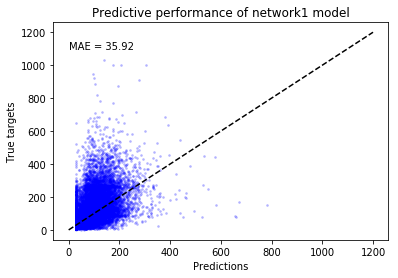

In [85]:
from keras.layers import Dropout
neurons = 48
np.random.seed(123)
Earlystopping_monitor = callbacks.EarlyStopping(patience=3)
    
network1 = models.Sequential()
network1.add(layers.Dense(neurons,activation="relu", input_shape = (X_train_trans_NNet.shape[1],)))
network1.add(layers.Dropout(rate = 0.01))
network1.add(layers.Dense(neurons,activation="relu"))
network1.add(layers.Dropout(rate = 0.01))
network1.add(layers.Dense(neurons,activation="relu"))
network1.add(layers.ActivityRegularization(l1 = 0.001, l2 = 0.001))
network1.add(layers.Dropout(rate = 0.01))
network1.add(layers.Dense(neurons,activation="relu"))
network1.add(layers.Dropout(rate = 0.01))
network1.add(layers.Dense(neurons,activation="relu"))
network1.add(layers.Dropout(rate = 0.01))
network1.add(layers.Dense(1))
network1.compile(optimizer= "adam", loss= "mean_absolute_error", metrics= [metrics.mean_absolute_error])
history_net1 = network1.fit(X_train_trans_NNet,np.log(y_train),  callbacks=[Earlystopping_monitor],
                                 epochs=100,batch_size=200,validation_split= 0.0, 
                                 validation_data = (X_val_trans_NNet,np.log(y_val)))
preds = network1.predict(X_val_trans_NNet)

# Out-of-box performance using validation set
mae = median_absolute_error(y_val,np.exp(preds)) 

plot_performance(true= y_val, preds= preds, model_name= "network1")

#### Bayesian Optimization

In [88]:
# We start by defining the score we want to be maximized using Bayesian Optimization
# Note that the parameters we will optimize are called as generic arguments

seed = 112 # Random seed

def network_score(neurons,dropoutrate, l1, l2, batch_size):
    from sklearn.metrics import roc_auc_score
    import numpy as np
    
    np.random.seed(123)
    Earlystopping_monitor = callbacks.EarlyStopping(patience=3)

    network1 = models.Sequential()
    network1.add(layers.Dense(int(neurons),activation="relu", input_shape = (X_train_trans_NNet.shape[1],)))
    network1.add(layers.Dropout(rate = dropoutrate))
    network1.add(layers.Dense(int(neurons),activation="relu"))
    network1.add(layers.Dropout(rate = dropoutrate))
    network1.add(layers.Dense(int(neurons),activation="relu"))
    network1.add(layers.ActivityRegularization(l1 = l1, l2 = l2))
    network1.add(layers.Dropout(rate = dropoutrate))
    network1.add(layers.Dense(int(neurons),activation="relu"))
    network1.add(layers.Dropout(rate = dropoutrate))
    network1.add(layers.Dense(int(neurons),activation="relu"))
    network1.add(layers.Dropout(rate = dropoutrate))
    network1.add(layers.Dense(1))
    network1.compile(optimizer= "adam", loss= "mean_absolute_error", metrics= [metrics.mean_absolute_error])
    history_net1 = network1.fit(X_train_trans_NNet,np.log(y_train),  callbacks=[Earlystopping_monitor],
                                     epochs=100,batch_size= int(batch_size),validation_split= 0.0, verbose= 0,
                                     validation_data = (X_val_trans_NNet,np.log(y_val)))
    preds = network1.predict(X_val_trans_NNet)

    # Out-of-box performance using validation set
    mae = median_absolute_error(y_val,np.exp(preds)) 
    
    # return the - mae to be maximized
    return - mae

In [89]:
import warnings
warnings.filterwarnings('ignore')

from bayes_opt import BayesianOptimization

# alpha is a parameter for the gaussian process
# Note that this is itself a hyperparemter that can be optimized.
gp_params = {"alpha": 1e-10}

# We create the BayesianOptimization objects using the functions that utilize
# the respective classifiers and return cross-validated scores to be optimized.

seed = 112 # Random seed

# We create the bayes_opt object and pass the function to be maximized
# together with the parameters names and their bounds.
# Note the syntax of bayes_opt package: bounds of hyperparameters are passed as two-tuples

hyperparameter_space = {
    'neurons': (6, 1000),
    'dropoutrate' : (0.01,0.1),
    'l1': (0,0.005),
    'l2': (0,0.005),
    'batch_size':(100,500)
}

networkBO = BayesianOptimization(f = network_score, 
                             pbounds =  hyperparameter_space,
                             random_state = seed,
                             verbose = 10)

# Finally we call .maximize method of the optimizer with the appropriate arguments
# kappa is a measure of 'aggressiveness' of the bayesian optimization process
# The algorithm will randomly choose 3 points to establish a 'prior', then will perform 
# 10 interations to maximize the value of estimator function
networkBO.maximize(init_points=100,n_iter=100,acq='ucb', kappa= 3, **gp_params)

Initialization
------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   batch_size |   dropoutrate |        l1 |        l2 |   neurons | 
    1 | 00m58s |  -50.17097 |     435.5589 |        0.0707 |    0.0036 |    0.0040 |  378.8068 | 
    2 | 01m22s |  -50.98121 |     331.1361 |        0.0250 |    0.0023 |    0.0036 |  642.4628 | 
    3 | 03m46s |  -57.01167 |     199.5564 |        0.0530 |    0.0025 |    0.0028 |  950.3165 | 
    4 | 00m30s |  -50.12281 |     327.4513 |        0.0713 |    0.0015 |    0.0033 |   81.2231 | 
    5 | 08m19s |  -35.79353 |     165.0661 |        0.0292 |    0.0004 |    0.0039 |  778.2681 | 
    6 | 01m59s |  -51.88293 |     249.9051 |        0.0456 |    0.0026 |    0.0040 |  833.7493 | 
    7 | 00m40s |  -50.98016 |     436.3453 |        0.0284 |    0.0027 |    0.0003 |   60.4769 | 
    8 | 02m45s |  -50.08791 |     271.3318 |        0.0281 |    0.0032 |    0.0042 |  818.7713 | 
    9 

   80 | 01m11s |  -50.13283 |     198.3313 |        0.0601 |    0.0011 |    0.0025 |   21.2438 | 
   81 | 00m55s |  -51.76659 |     122.5704 |        0.0282 |    0.0036 |    0.0024 |   79.8402 | 
   82 | 06m43s |  -35.14655 |     147.2906 |        0.0730 |    0.0015 |    0.0026 |  501.9495 | 
   83 | 06m08s |  -34.77218 |     159.3061 |        0.0644 |    0.0038 |    0.0043 |  304.1015 | 
   84 | 01m19s |  -51.07821 |     131.3776 |        0.0767 |    0.0016 |    0.0017 |   38.7896 | 
   85 | 01m12s |  -34.63953 |     286.5972 |        0.0385 |    0.0003 |    0.0005 |   52.2423 | 
   86 | 06m34s |  -37.26810 |     121.5394 |        0.0921 |    0.0004 |    0.0042 |  609.0147 | 
   87 | 01m56s |  -50.15553 |     415.4781 |        0.0677 |    0.0034 |    0.0002 |  726.7912 | 
   88 | 05m55s |  -37.79434 |     349.4865 |        0.0963 |    0.0019 |    0.0045 |  459.4445 | 
   89 | 01m43s |  -51.75925 |     161.6043 |        0.0174 |    0.0015 |    0.0002 |   66.3478 | 
   90 | 01m45s |  -5

  162 | 03m54s |  -50.41669 |     447.2611 |        0.1000 |    0.0050 |    0.0000 |  882.2901 | 
  163 | 06m20s |  -58.37084 |     213.8851 |        0.0100 |    0.0050 |    0.0000 | 1000.0000 | 
  164 | 09m02s |  -33.70222 |     149.2199 |        0.1000 |    0.0000 |    0.0000 |  133.4111 | 
  165 | 05m18s |  -52.99882 |     100.0000 |        0.0100 |    0.0050 |    0.0050 |  311.2666 | 
  166 | 06m52s |  -36.75412 |     301.4026 |        0.0100 |    0.0000 |    0.0050 | 1000.0000 | 
  167 | 05m27s |  -32.91270 |     166.0847 |        0.1000 |    0.0000 |    0.0050 |  610.2132 | 
  168 | 03m02s |  -50.71375 |     234.1880 |        0.0100 |    0.0050 |    0.0050 |   58.3707 | 
  169 | 02m54s |  -50.84854 |     100.0000 |        0.0100 |    0.0050 |    0.0000 |    6.0000 | 
  170 | 04m13s |  -38.52116 |     292.3813 |        0.0100 |    0.0000 |    0.0050 |  405.3404 | 
  171 | 04m34s |  -52.91975 |     264.6197 |        0.1000 |    0.0050 |    0.0000 |  607.4676 | 
  172 | 03m44s |  -5

KeyboardInterrupt: 

Next, we will try to tune the number of neurons at each layer seperately to see if that makes any difference:

In [90]:
# We start by defining the score we want to be maximized using Bayesian Optimization
# Note that the parameters we will optimize are called as generic arguments

seed = 112 # Random seed

def network_score(neurons1,neurons2,neurons3,neurons4,neurons5,dropoutrate, l1, l2, batch_size):
    from sklearn.metrics import roc_auc_score
    import numpy as np
    
    np.random.seed(123)
    Earlystopping_monitor = callbacks.EarlyStopping(patience=3)

    network1 = models.Sequential()
    network1.add(layers.Dense(int(neurons1),activation="relu", input_shape = (X_train_trans_NNet.shape[1],)))
    network1.add(layers.Dropout(rate = dropoutrate))
    network1.add(layers.Dense(int(neurons2),activation="relu"))
    network1.add(layers.Dropout(rate = dropoutrate))
    network1.add(layers.Dense(int(neurons3),activation="relu"))
    network1.add(layers.ActivityRegularization(l1 = l1, l2 = l2))
    network1.add(layers.Dropout(rate = dropoutrate))
    network1.add(layers.Dense(int(neurons4),activation="relu"))
    network1.add(layers.Dropout(rate = dropoutrate))
    network1.add(layers.Dense(int(neurons5),activation="relu"))
    network1.add(layers.Dropout(rate = dropoutrate))
    network1.add(layers.Dense(1))
    network1.compile(optimizer= "adam", loss= "mean_absolute_error", metrics= [metrics.mean_absolute_error])
    history_net1 = network1.fit(X_train_trans_NNet,np.log(y_train),  callbacks=[Earlystopping_monitor],
                                     epochs=100,batch_size= int(batch_size),validation_split= 0.0, verbose= 0,
                                     validation_data = (X_val_trans_NNet,np.log(y_val)))
    preds = network1.predict(X_val_trans_NNet)

    # Out-of-box performance using validation set
    mae = median_absolute_error(y_val,np.exp(preds)) 
    
    # return the - mae to be maximized
    return - mae

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from bayes_opt import BayesianOptimization

# alpha is a parameter for the gaussian process
# Note that this is itself a hyperparemter that can be optimized.
gp_params = {"alpha": 1e-10}

# We create the BayesianOptimization objects using the functions that utilize
# the respective classifiers and return cross-validated scores to be optimized.

seed = 112 # Random seed

# We create the bayes_opt object and pass the function to be maximized
# together with the parameters names and their bounds.
# Note the syntax of bayes_opt package: bounds of hyperparameters are passed as two-tuples

hyperparameter_space = {
    'neurons1': (6, 1000),
    'neurons2': (6, 1000),
    'neurons3': (6, 1000),
    'neurons4': (6, 1000),
    'neurons5': (6, 1000),
    'dropoutrate' : (0.01,0.1),
    'l1': (0,0.005),
    'l2': (0,0.005),
    'batch_size':(100,1000)
}

networkBO = BayesianOptimization(f = network_score, 
                             pbounds =  hyperparameter_space,
                             random_state = seed,
                             verbose = 10)

# Finally we call .maximize method of the optimizer with the appropriate arguments
# kappa is a measure of 'aggressiveness' of the bayesian optimization process
# The algorithm will randomly choose 3 points to establish a 'prior', then will perform 
# 10 interations to maximize the value of estimator function
networkBO.maximize(init_points=100,n_iter=100,acq='ucb', kappa= 3, **gp_params)

Initialization
-----------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   batch_size |   dropoutrate |        l1 |        l2 |   neurons1 |   neurons2 |   neurons3 |   neurons4 |   neurons5 | 
    1 | 01m59s |  -50.83699 |     439.0547 |        0.0240 |    0.0031 |    0.0013 |   378.8068 |   676.5267 |   719.8727 |   809.7351 |   839.8639 | 
    2 | 02m47s |  -51.09654 |     233.6223 |        0.0180 |    0.0024 |    0.0032 |   642.4628 |   172.1404 |   468.6908 |   721.7213 |   580.3732 | 
    3 | 04m19s |  -52.16850 |     296.3083 |        0.0595 |    0.0018 |    0.0014 |   950.3165 |   481.2698 |   498.3241 |   568.6497 |   253.3976 | 
    4 | 02m27s |  -52.66494 |     319.7375 |        0.0760 |    0.0041 |    0.0042 |    81.2231 |   683.0308 |   301.2569 |   661.2474 |   571.2165 | 
